# Análisis de Churn de Clientes – Telecom X

## Introducción
Telecom X enfrenta una alta tasa de evasión de clientes. Este análisis busca identificar los factores que influyen en la cancelación de servicios, para apoyar al equipo de Data Science en la construcción de un modelo predictivo.

##Importar librerías y cargar datos

In [29]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()

In [13]:
# Aplanar el JSON anidado
df = pd.json_normalize(data)

In [20]:
df.columns = [
    col.replace('customer.', '').replace('phone.', '').replace('internet.', '').replace('account.', '')
    for col in df.columns
]

In [22]:
print(df.columns)

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly',
       'Charges.Total'],
      dtype='object')


In [30]:
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


## Conociendo el conjunto de datos

In [34]:
print("Número de filas:", df.shape[0])
print("Número de columnas:", df.shape[1])
print("\nTipos de datos:")
print(df.dtypes)

Número de filas: 7256
Número de columnas: 22

Tipos de datos:
customerID           object
Churn                object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
Charges.Monthly     float64
Charges.Total       float64
Cuentas_Diarias     float64
dtype: object


## Comprobación de inconsistencias

In [36]:
print("Valores nulos por columna:")
print(df.isnull().sum())
print(f"\nFilas duplicadas: {df.duplicated().sum()}")

Valores nulos por columna:
customerID          0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Charges.Monthly     0
Charges.Total       0
Cuentas_Diarias     0
dtype: int64

Filas duplicadas: 0


### Limpieza y transformación de datos

In [23]:
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')

In [38]:
df.dropna(inplace=True)

In [42]:
cols_to_map = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
for col in cols_to_map:
    if col in df.columns:
        df[col] = df[col].map({'Sí': 'Yes', 'No': 'No'})

In [43]:
df['Cuentas_Diarias'] = df['Charges.Monthly'] / 30

## Análisis descriptivo

In [45]:
df[['tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']].describe()

,tenure,Charges.Monthly,Charges.Total,Cuentas_Diarias
count,7256.000000,7256.000000,7256.000000,7256.000000
mean,32.395535,64.755423,2280.634213,2.158514
std,24.558067,30.125739,2268.632997,1.004191
min,1.000000,18.250000,18.800000,0.608333
25%,9.000000,35.450000,400.225000,1.181667
50%,29.000000,70.300000,1391.000000,2.343333
75%,55.000000,89.900000,3785.300000,2.996667
max,72.000000,118.750000,8684.800000,3.958333


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7256 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7256 non-null   object 
 1   Churn             7256 non-null   object 
 2   gender            7256 non-null   object 
 3   SeniorCitizen     7256 non-null   int64  
 4   Partner           7256 non-null   object 
 5   Dependents        7256 non-null   object 
 6   tenure            7256 non-null   int64  
 7   PhoneService      7256 non-null   object 
 8   MultipleLines     7256 non-null   object 
 9   InternetService   7256 non-null   object 
 10  OnlineSecurity    7256 non-null   object 
 11  OnlineBackup      7256 non-null   object 
 12  DeviceProtection  7256 non-null   object 
 13  TechSupport       7256 non-null   object 
 14  StreamingTV       7256 non-null   object 
 15  StreamingMovies   7256 non-null   object 
 16  Contract          7256 non-null   object 
 17  

## Distribución de la evasión (Churn)
### ¿Cuántos clientes se han ido?

/tmp/ipython-input-1884847415.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='Set2')


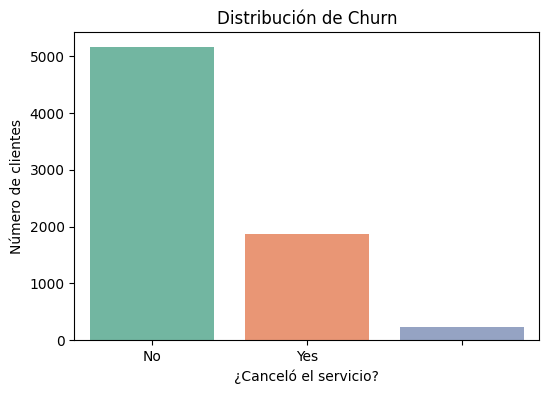

In [48]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title('Distribución de Churn')
plt.xlabel('¿Canceló el servicio?')
plt.ylabel('Número de clientes')
plt.show()

## Churn por variables categóricas
### ¿Qué perfiles de clientes cancelan más?

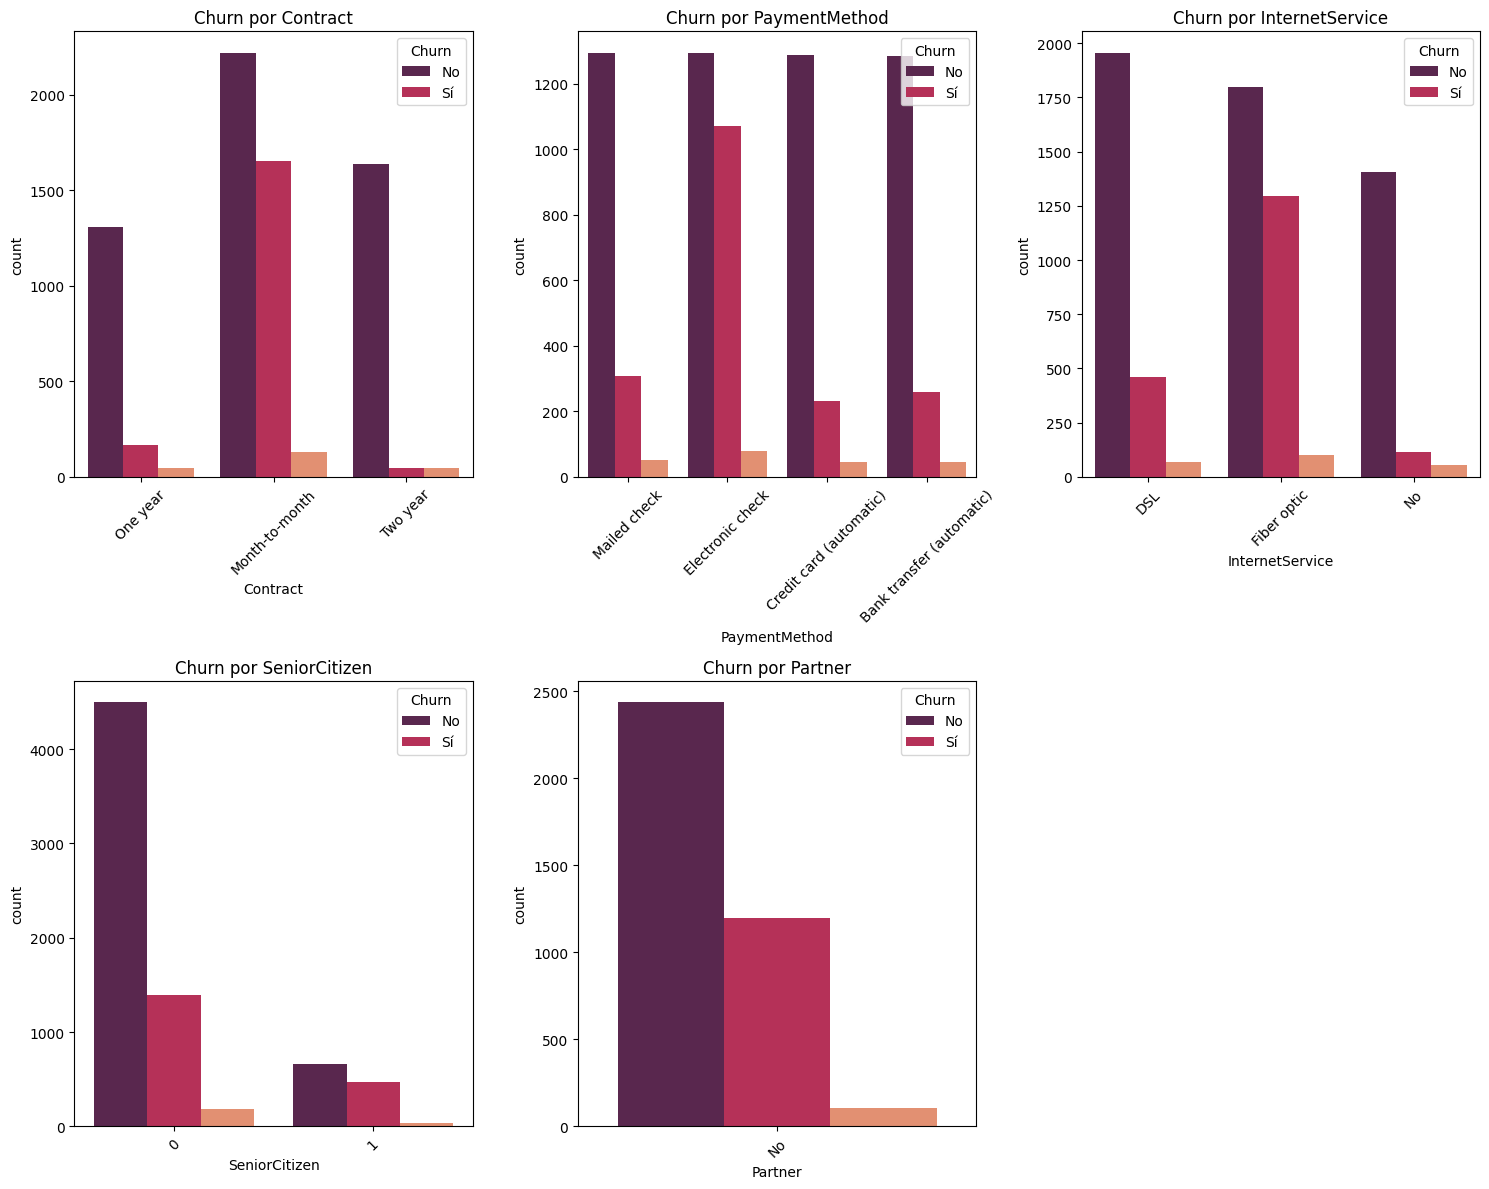

In [51]:
categorical_cols = ['Contract', 'PaymentMethod', 'InternetService', 'SeniorCitizen', 'Partner']

plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df, x=col, hue='Churn', palette='rocket')
    plt.title(f'Churn por {col}')
    plt.xticks(rotation=45)
    plt.legend(title='Churn', labels=['No', 'Sí'])

plt.tight_layout()
plt.show()

## Churn por variables numéricas
### ¿Cómo afectan el tiempo y el costo al churn?

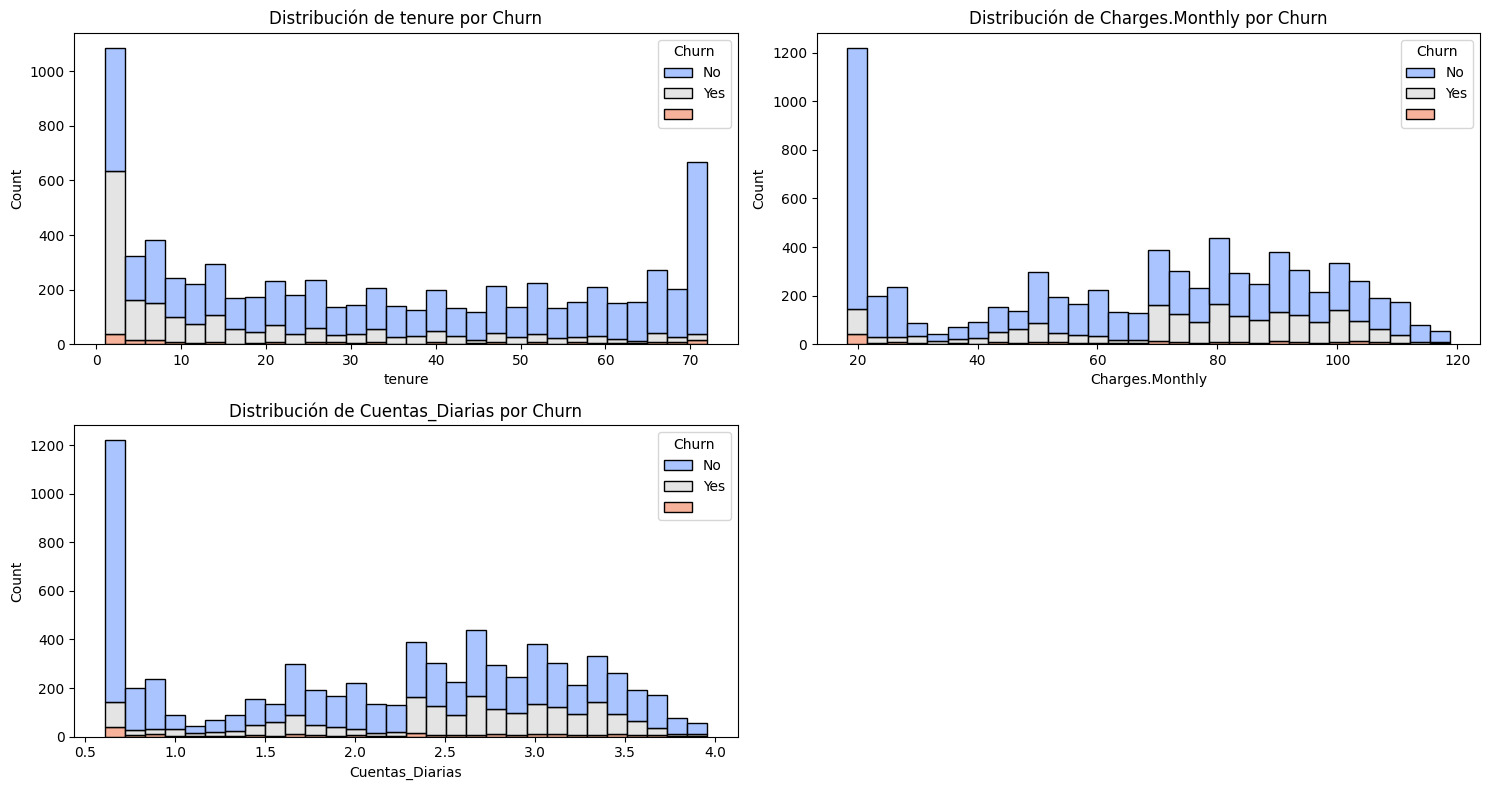

In [53]:
numeric_cols = ['tenure', 'Charges.Monthly', 'Cuentas_Diarias']

plt.figure(figsize=(15, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=col, hue='Churn', multiple='stack', bins=30, palette='coolwarm')
    plt.title(f'Distribución de {col} por Churn')

plt.tight_layout()
plt.show()

## Hallazgos clave
- **Churn general**: ~26% de los clientes han cancelado.
- **Contrato mensual**: Muy alta tasa de churn.
- **Clientes nuevos**: Los primeros 12 meses son críticos.
- **Alto cargo mensual**: Asociado a mayor cancelación.
- **Sin pareja o dependientes**: Mayor riesgo de churn.
- **Facturación electrónica**: Más común entre quienes cancelan.

## Recomendaciones
1. **Ofrecer descuentos en contratos anuales** para nuevos clientes.
2. **Programa de retención** en los primeros 6 meses.
3. **Personalizar ofertas** para clientes con alto `Charges.Monthly`.
4. **Mejorar soporte técnico** para usuarios de fibra óptica.
5. **Comunicación proactiva** con clientes solteros sin dependientes.